In [2]:
import numpy as np
import pandas as pd
import pickle
import os
import gdown
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
import joblib
import time

/Users/tonymontalto/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Import Models and Datasets

In [3]:
# Should take about 3 minutes if files not already present
# Import pretrained models
path = "./"
m = "model_"
models = ["lr.sav", "rf.sav", "xgb.sav", "ffnn.keras", "cnn.keras"]
model_urls = [
    "https://drive.google.com/file/d/1cQfOEH3b6-dxVMkEL2aM8N5p5Zt9jNJw/view?usp=drive_link",
    "https://drive.google.com/file/d/1OqREa20mOlTnZVdsZ-_lKBfkwIl4fJYG/view?usp=drive_link",
    "https://drive.google.com/file/d/1Q4mzsXIL4bX8sXpG6mMpvjCmvXgT9eh2/view?usp=drive_link",
    "https://drive.google.com/file/d/1AV2IFpEU7EGn4ZOJWgmKdoq-ghxUaEjD/view?usp=drive_link",
    "https://drive.google.com/file/d/1Try-1FfpfbXPJGq94wm9ZuawaZHZIzuU/view?usp=drive_link",
]

# Import Incompleted studies to add to Dashboard DataFrame
x = "X_"
y = "y_"
incompleted = "incompleted.pkl"
groups = ["X_incompleted.pkl", "X_incompleted_pca.pkl", "y_incompleted.pkl"]
group_urls = [
    "https://drive.google.com/file/d/1-EmGbMENBqMZwH9xxyNujwKnsDiVL3mD/view?usp=drive_link",
    "https://drive.google.com/file/d/1RQgpE9CgNhpJAKqIX5z_wi3yItRu7pCo/view?usp=drive_link",
    "https://drive.google.com/file/d/1Z3KF8b1ntL5quFkv71aGD0vF6DNM8S4Q/view?usp=drive_link",
]

for i, model in enumerate(models):
    if os.path.isfile(path + m + model):
        pass
    else:
        output = m + model

        gdown.download(model_urls[i], output, fuzzy=True)


for i, group in enumerate(groups):
    if os.path.isfile(path + group):
        pass
    else:
        output = group

        gdown.download(group_urls[i], output, fuzzy=True)

In [4]:
# import Dashboard DataFrame
if os.path.isfile("./study_info_df.csv"):
    pass
else:
    # Should only take ~30 seconds
    url = "https://drive.google.com/file/d/1sSYhHvWkYVRFoB1ulEblmTwo9iSibYpG/view?usp=drive_link"

    output = "study_info_df.csv"

    gdown.download(url, output, fuzzy=True)

study_info_df = pd.read_csv("./study_info_df.csv")
study_info_df

,nctId,status,phases,description,inclusion_criteria,exclusion_criteria,intervention_type,intervention_name,disease,outcome_measures,outcome_timeframes,durationMonths
0,NCT03202394,COMPLETED,['PHASE2'],"This is a randomized, double blind, placebo co...",Inclusion Criteria:\n\n1. Has provided (or rel...,:\n\n1. Age \< 18 years or \>75 years old\n2. ...,"['DRUG', 'DRUG']","['BIO-11006', 'Placebo']","['Respiratory Distress Syndrome, Adult']",['Incidence of treatment-emergent adverse even...,['28 days'],32.266667
1,NCT02138214,COMPLETED,['PHASE2'],PRIMARY OBJECTIVES:\n\nI. To determine the rat...,Inclusion Criteria:\n\n* Pre-operative diagnos...,:\n\n* Largest papillary thyroid carcinoma \< ...,"['PROCEDURE', 'PROCEDURE', 'OTHER']","['Thyroidectomy', 'entral lymph node dissectio...","['Stage I Papillary Thyroid Cancer', 'Stage II...",['Percentage of Participants With Transient Hy...,"['Post-operative day 1', 'At day 12', '2 weeks...",65.733333
2,NCT00976274,COMPLETED,['NA'],The details of study objective are followed by...,Inclusion Criteria:(three or more of following...,: (any one of following factors)\n\n* uncontro...,"['DIETARY_SUPPLEMENT', 'DIETARY_SUPPLEMENT']","['Korean red ginseng', 'starch']",['Metabolic Syndrome'],['Change in the Pre- and Post-treatment Systol...,['baseline and 12 weeks'],17.266667
3,NCT05529719,COMPLETED,['NA'],Objective: This study evaluates the effect of ...,Inclusion Criteria:\n\n* 18 to 30 years of age...,:\n\n* Volunteers who did not meet the inclusi...,['OTHER'],['Clinical Pilates Exercises'],['Low Back Pain'],['Prim Outcome - Oswestry Dysability Index'],['12 weeks'],25.266667
4,NCT02323191,COMPLETED,['PHASE1'],"This Phase 1, open-label, multicenter, global ...",Inclusion Criteria:\n\n* Eastern Cooperative O...,\n* Measurable disease at baseline as per RECI...,"['DRUG', 'DRUG']","['Atezolizumab', 'Emactuzumab']",['Solid Cancers'],['Percentage of Participants With Dose Limitin...,"['21 days', '21 days', 'Baseline up to 3 years']",68.033333
...,...,...,...,...,...,...,...,...,...,...,...,...
184620,NCT05883852,RECRUITING,['PHASE3'],The objective of this study is to conduct a ra...,Inclusion Criteria:\n\n* Women aged 18-70；\n* ...,:\n\n* Bilateral breast cancer or carcinoma in...,"['DRUG', 'DRUG', 'DRUG', 'DRUG', 'DRUG', 'DRUG']","['Docetaxel', 'carboplatin', 'Trastuzumab', 'P...",['HER2 Positive Early Breast Cancer'],['iDFS'],['5 years'],98.200000
184621,NCT02180724,ACTIVE_NOT_RECRUITING,['PHASE2'],Clinical studies have shown that targeting the...,Inclusion Criteria:\n\n1. Men and women ≥18 ye...,":\n\n1. Prior malignancy, except for adequatel...","['DRUG', 'DRUG']","['Acalabrutinib (ACP-196)', 'Acalabrutinib (AC...",['Waldenström Macroglobulinemia (WM)'],['Overall Response Rate (ORR) of Acalabrutinib...,['Up to approximately 3.8 years. Data cut at w...,61.633333
184622,NCT00487305,ACTIVE_NOT_RECRUITING,['PHASE1'],* The dose of vaccine will depend upon how man...,Inclusion Criteria:\n\n* Histologically confir...,:\n\n* Uncontrolled active infection or illnes...,['BIOLOGICAL'],['Lethally Irradiated Lymphoma cells with GM-C...,['Follicular Lymphoma'],['To determine the safety and toxicity of admi...,['2 years'],195.800000
184623,NCT05786924,RECRUITING,['PHASE1'],"BDTX-4933-101 is a first-in-human, open-label,...",Key Inclusion Criteria:\n\n1. Disease criteria...,:\n\n1. Cancer that has a known MEK1/2 mutatio...,['DRUG'],['BDTX-4933'],"['Non-small Cell Lung Cancer', 'Histiocytic Ne...",['Dose Escalation: Incidence of dose-limiting ...,"['The first 28-day cycle (Cycle 1)', 'Day 1 of...",38.000000


In [5]:
# Test
# with open("../_test/X_test.pkl", "rb") as file:
#     X_test = pickle.load(file)

# with open("../_test/y_test.pkl", "rb") as file:
#     y_test = pickle.load(file)

# Incomplete
with open("./X_incompleted.pkl", "rb") as file:
    X_incompleted = pickle.load(file)

with open("./y_incompleted.pkl", "rb") as file:
    y_incompleted = pickle.load(file)

# PCA versions
# with open("../_test/X_train_pca.pkl", "rb") as file:
#     X_train_pca = pickle.load(file)

with open("./X_incompleted_pca.pkl", "rb") as file:
    X_incompleted_pca = pickle.load(file)

# Linear Regression

In [6]:
# Load in pretrained model and get predicted values
lr = joblib.load("./model_lr.sav")
y_pred_lr = lr.predict(X_incompleted)
y_pred_lr
# print(lr.score)

array([19.69473811, 19.36546213,  5.28051592, ..., 71.65103307,
       54.29086775, 26.15483794])

# Random Forest

In [7]:
# Load in pretrained model and get predicted values
rf = joblib.load("./model_rf.sav")
y_pred_rf = rf.predict(X_incompleted_pca)
y_pred_rf

array([40.26951708, 15.44139709, 24.77514241, ..., 63.95204551,
       52.45273405, 21.9216853 ])

# XGBoost

In [8]:
# Load in pretrained model and get predicted values
with open("./model_xgb.sav", "rb") as f:
    xg = pickle.load(f)

y_pred_xgb = xg.predict(X_incompleted_pca)
y_pred_xgb

array([41.311485, 16.102915, 22.86373 , ..., 69.25941 , 54.54035 ,
       15.755807], dtype=float32)

# FFNN

In [9]:
# Load in pretrained model and get predicted values
ffnn = load_model(
    "./model_ffnn.keras", custom_objects=None, compile=True, safe_mode=True
)
y_pred_ffnn = ffnn.predict(X_incompleted)
y_pred_ffnn

1612/1612 ━━━━━━━━━━━━━━━━━━━━ 2s 701us/step


array([[25.756372],
       [13.539691],
       [17.498016],
       ...,
       [57.744637],
       [50.911907],
       [26.661886]], dtype=float32)

# CNN

In [10]:
# Load in pretrained model and get predicted values
cnn = load_model(
     "./model_cnn.keras", custom_objects=None, compile=True, safe_mode=True
)
y_pred_cnn = cnn.predict(X_incompleted)
y_pred_cnn

1612/1612 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step


array([[27.747698],
       [13.165504],
       [19.505201],
       ...,
       [61.07513 ],
       [50.798626],
       [22.996641]], dtype=float32)

# Combine All Model Predictions

In [11]:
# Compare the mse to see which predictions to use
preds = [y_pred_lr, y_pred_rf, y_pred_xgb, y_pred_ffnn, y_pred_cnn]
models = ["Linear Regression", "Random Forest", "XGBoost", "FFNN", "CNN"]

for i, p in enumerate(preds):
    try:
        mse = mean_squared_error(y_incompleted, p)
    except:
        mse = mean_squared_error(y_test, p)

    print(models[i], mse)
    # Around 29 error

Linear Regression 834.8014383046133
Random Forest 885.2747287659091
XGBoost 821.7040187854658
FFNN 821.5441732255206
CNN 823.3580548682285


# Add best model predictions to Dashboard DataFrame

In [12]:
# DELETE ONCE WHOLE NOTEBOOK WORKS
# study_info_df = pd.read_csv("./study_info_df.csv")

study_info_df

,nctId,status,phases,description,inclusion_criteria,exclusion_criteria,intervention_type,intervention_name,disease,outcome_measures,outcome_timeframes,durationMonths
0,NCT03202394,COMPLETED,['PHASE2'],"This is a randomized, double blind, placebo co...",Inclusion Criteria:\n\n1. Has provided (or rel...,:\n\n1. Age \< 18 years or \>75 years old\n2. ...,"['DRUG', 'DRUG']","['BIO-11006', 'Placebo']","['Respiratory Distress Syndrome, Adult']",['Incidence of treatment-emergent adverse even...,['28 days'],32.266667
1,NCT02138214,COMPLETED,['PHASE2'],PRIMARY OBJECTIVES:\n\nI. To determine the rat...,Inclusion Criteria:\n\n* Pre-operative diagnos...,:\n\n* Largest papillary thyroid carcinoma \< ...,"['PROCEDURE', 'PROCEDURE', 'OTHER']","['Thyroidectomy', 'entral lymph node dissectio...","['Stage I Papillary Thyroid Cancer', 'Stage II...",['Percentage of Participants With Transient Hy...,"['Post-operative day 1', 'At day 12', '2 weeks...",65.733333
2,NCT00976274,COMPLETED,['NA'],The details of study objective are followed by...,Inclusion Criteria:(three or more of following...,: (any one of following factors)\n\n* uncontro...,"['DIETARY_SUPPLEMENT', 'DIETARY_SUPPLEMENT']","['Korean red ginseng', 'starch']",['Metabolic Syndrome'],['Change in the Pre- and Post-treatment Systol...,['baseline and 12 weeks'],17.266667
3,NCT05529719,COMPLETED,['NA'],Objective: This study evaluates the effect of ...,Inclusion Criteria:\n\n* 18 to 30 years of age...,:\n\n* Volunteers who did not meet the inclusi...,['OTHER'],['Clinical Pilates Exercises'],['Low Back Pain'],['Prim Outcome - Oswestry Dysability Index'],['12 weeks'],25.266667
4,NCT02323191,COMPLETED,['PHASE1'],"This Phase 1, open-label, multicenter, global ...",Inclusion Criteria:\n\n* Eastern Cooperative O...,\n* Measurable disease at baseline as per RECI...,"['DRUG', 'DRUG']","['Atezolizumab', 'Emactuzumab']",['Solid Cancers'],['Percentage of Participants With Dose Limitin...,"['21 days', '21 days', 'Baseline up to 3 years']",68.033333
...,...,...,...,...,...,...,...,...,...,...,...,...
184620,NCT05883852,RECRUITING,['PHASE3'],The objective of this study is to conduct a ra...,Inclusion Criteria:\n\n* Women aged 18-70；\n* ...,:\n\n* Bilateral breast cancer or carcinoma in...,"['DRUG', 'DRUG', 'DRUG', 'DRUG', 'DRUG', 'DRUG']","['Docetaxel', 'carboplatin', 'Trastuzumab', 'P...",['HER2 Positive Early Breast Cancer'],['iDFS'],['5 years'],98.200000
184621,NCT02180724,ACTIVE_NOT_RECRUITING,['PHASE2'],Clinical studies have shown that targeting the...,Inclusion Criteria:\n\n1. Men and women ≥18 ye...,":\n\n1. Prior malignancy, except for adequatel...","['DRUG', 'DRUG']","['Acalabrutinib (ACP-196)', 'Acalabrutinib (AC...",['Waldenström Macroglobulinemia (WM)'],['Overall Response Rate (ORR) of Acalabrutinib...,['Up to approximately 3.8 years. Data cut at w...,61.633333
184622,NCT00487305,ACTIVE_NOT_RECRUITING,['PHASE1'],* The dose of vaccine will depend upon how man...,Inclusion Criteria:\n\n* Histologically confir...,:\n\n* Uncontrolled active infection or illnes...,['BIOLOGICAL'],['Lethally Irradiated Lymphoma cells with GM-C...,['Follicular Lymphoma'],['To determine the safety and toxicity of admi...,['2 years'],195.800000
184623,NCT05786924,RECRUITING,['PHASE1'],"BDTX-4933-101 is a first-in-human, open-label,...",Key Inclusion Criteria:\n\n1. Disease criteria...,:\n\n1. Cancer that has a known MEK1/2 mutatio...,['DRUG'],['BDTX-4933'],"['Non-small Cell Lung Cancer', 'Histiocytic Ne...",['Dose Escalation: Incidence of dose-limiting ...,"['The first 28-day cycle (Cycle 1)', 'Day 1 of...",38.000000


In [13]:
# Get incompleted NCTIDs to use to merge with Dashboard DataFrame
incompleted_ids = pd.read_csv("../results/incompleted_ids.csv")
incompleted_ids

,nctId,status,studyType,primaryPurpose
0,NCT05499390,ACTIVE_NOT_RECRUITING,INTERVENTIONAL,TREATMENT
1,NCT05441683,RECRUITING,INTERVENTIONAL,TREATMENT
2,NCT05613686,RECRUITING,INTERVENTIONAL,TREATMENT
3,NCT05497843,RECRUITING,INTERVENTIONAL,TREATMENT
4,NCT06157541,RECRUITING,INTERVENTIONAL,TREATMENT
...,...,...,...,...
52164,NCT05883852,RECRUITING,INTERVENTIONAL,TREATMENT
52165,NCT02180724,ACTIVE_NOT_RECRUITING,INTERVENTIONAL,TREATMENT
52166,NCT00487305,ACTIVE_NOT_RECRUITING,INTERVENTIONAL,TREATMENT
52167,NCT05786924,RECRUITING,INTERVENTIONAL,TREATMENT


In [14]:
# Add predicted durations onto df, removing ones that were unable to be embedded due to NaNs
incompleted_preds_df = study_info_df[
    study_info_df.nctId.isin(list(incompleted_ids.nctId))
].dropna(
    subset=[
        "intervention_name",
        "exclusion_criteria",
        "outcome_measures",
        "outcome_timeframes",
    ]
)
incompleted_preds_df["predicted_durationMonths"] = y_pred_ffnn
incompleted_preds_df = incompleted_preds_df[
    ["nctId", "predicted_durationMonths"]
].reset_index(drop=True)
incompleted_preds_df

,nctId,predicted_durationMonths
0,NCT05499390,25.756372
1,NCT05441683,13.539691
2,NCT05613686,17.498016
3,NCT05497843,38.387852
4,NCT06157541,42.911945
...,...,...
51548,NCT05883852,48.514359
51549,NCT02180724,25.597454
51550,NCT00487305,57.744637
51551,NCT05786924,50.911907


In [15]:
# Save for use with TrialDuraPredict_Dashboard Jupyter Notebook file
incompleted_preds_df.to_csv("../results/incompleted_preds_df.csv", index=False)

# Scoring Predictions

MSE:
Linear Regression:  834.8014383046133
Random Forest Regresion:  885.2747287659091
XGBoost:  821.7040187854658
FFNN:  821.5441732255206
CNN:  823.3580548682285

R²
Linear Regression:  0.24654237929312162
Random Forest Regresion:  0.2009872525345373
XGBoost:  0.25836357424498724
FFNN:  0.25850784430700524
CNN:  0.25687070895475406


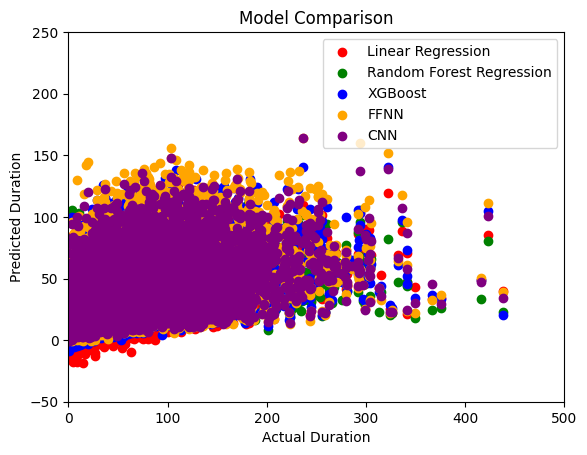

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

#y_pred_xgb, y_pred_ffnn, y_pred_cnn
# Calculate Mean Squared Error (MSE) and R-squared (R²)
mse_lr = mean_squared_error(y_incompleted, y_pred_lr)
mse_rf = mean_squared_error(y_incompleted, y_pred_rf)
mse_xgb = mean_squared_error(y_incompleted, y_pred_xgb)
mse_ffnn = mean_squared_error(y_incompleted, y_pred_ffnn)
mse_cnn = mean_squared_error(y_incompleted, y_pred_cnn)

r2_lr = r2_score(y_incompleted, y_pred_lr)
r2_rf = r2_score(y_incompleted, y_pred_rf)
r2_xgb = r2_score(y_incompleted, y_pred_xgb)
r2_ffnn = r2_score(y_incompleted, y_pred_ffnn)
r2_cnn = r2_score(y_incompleted, y_pred_cnn)

print("MSE:")
print("Linear Regression: ", mse_lr)
print("Random Forest Regresion: ", mse_rf)
print("XGBoost: ", mse_xgb)
print("FFNN: ", mse_ffnn)
print("CNN: ", mse_cnn)

print("\nR²")
print("Linear Regression: ", r2_lr)
print("Random Forest Regresion: ", r2_rf)
print("XGBoost: ", r2_xgb)
print("FFNN: ", r2_ffnn)
print("CNN: ", r2_cnn)

# Plot the results
plt.scatter(y_incompleted, y_pred_lr, label='Linear Regression', color='r')
plt.scatter(y_incompleted, y_pred_rf, label='Random Forest Regression', color='g')
plt.scatter(y_incompleted, y_pred_xgb, label='XGBoost', color='b')
plt.scatter(y_incompleted, y_pred_ffnn, label='FFNN', color='orange')
plt.scatter(y_incompleted, y_pred_cnn, label='CNN', color='purple')
plt.xlabel("Actual Duration")
plt.ylabel("Predicted Duration")
plt.legend()
plt.title("Model Comparison")
plt.axis([0, 500, -50, 250])
plt.show()

The MSE measures the average squared difference between the actual values and the values predicted by the models. Therefore, the model with the lowest MSE would be a better fit for the data. In this case, that is the FNN model. 
<br>The R² value represents the proportion of the variance in the values that can be explained by the models. The FNN R² value of 0.2585 means that the model explains 25.85% of the variance in the target variable. This is the highest of all of our R² values, which means that it is the best fit for our data.